### This Jupyter Notebook script is part of the Mistry & Gasparrani (2024) paper "Real-time forecast of temperature-related excess mortality at small-area level: towards an operational framework" published in Environmental Research: Health. The code documented here demonstrates how to access the high-resolution (0.25 deg gridded) temperature forecast from the ECMWF using the Python open-data package. 

### Note: The gridded temperature data used in the study was at 0.4 deg resolution. ECMWF has since updated their data policy and made even higher resolution data (0.25 deg) publicly available. Nonetheless, the aggregation of the gridded data to LSOA boundaries (in England & Wales; see paper) is done in R for further analyses. These LSOA-level temperature series are provided in the Github repo (see Mistry & Gasparrini 2024 for further details).

### The demo notebook here shows how to download the newer 0.25 deg forecast for the same days (17-22 July) but for 2024 instead of 2022 (How to access the recent available forecast is also demonstrated). Since the ECMWF has archieved the earlier 0.4 deg forecast data, it is no longer possible to download the same (i.e., forecast data prior approx Jan 2024 cannot be accessed using this open-data framework).

#### Attribution: Copyright statement: Copyright "© [2024] European Centre for Medium-Range Weather Forecasts (ECMWF)".
Source www.ecmwf.int
Licence Statement: This data is published under a Creative Commons Attribution 4.0 International (CC BY 4.0). https://creativecommons.org/licenses/by/4.0/
Disclaimer: ECMWF does not accept any liability whatsoever for any error or omission in the data, their availability, or for any loss or damage arising from their use.
Where applicable, an indication if the material has been modified and an indication of previous modifications.
The following wording shall be attached to services created with this ECMWF dataset:
Copyright statement: Copyright "This service is based on data and products of the European Centre for Medium-Range Weather Forecasts (ECMWF)".
Source www.ecmwf.int
Licence Statement: This ECMWF data is published under a Creative Commons Attribution 4.0 International (CC BY 4.0). https://creativecommons.org/licenses/by/4.0/
Disclaimer: ECMWF does not accept any liability whatsoever for any error or omission in the data, their availability, or for any loss or damage arising from their use.
Where applicable, an indication if the material has been modified and an indication of previous modifications

### Link the ECMWF-Opendata package and open-data forecast repository
### https://github.com/ecmwf/ecmwf-opendata
### https://www.ecmwf.int/en/forecasts/datasets/open-data

#### Install required python packages

In [1]:
'''
!pip install ecmwf-opendata
!pip install ecmwf-data ecmwf-api-client magpye
!pip install cfgrib
!pip install --upgrade google-api-python-client
!pip install cartopy        # Only for plotting. Use below if pip doesn't work
!conda install -c conda-forge cartopy -y  
!pip install rasterio rioxarray  # Only for plotting
'''

"\n!pip install ecmwf-opendata\n!pip install ecmwf-data ecmwf-api-client magpye\n!pip install cfgrib\n!pip install --upgrade google-api-python-client\n!pip install cartopy        # Only for plotting. Use below if pip doesn't work\n!conda install -c conda-forge cartopy -y  \n!pip install rasterio rioxarray  # Only for plotting\n"

In [1]:
import ecmwf.data as ecdata
from magpye import GeoMap
from ecmwfapi import *
import requests
from ecmwf.opendata import Client
import xarray as xr
import pandas as pd
import numpy as np
import cfgrib

## Only for Plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import rasterio
import rioxarray

### Check the latest available forecast

In [2]:
client = Client(source="ecmwf")

result=client.retrieve(
   # time=0,
    stream="oper",
    type="fc",
    step=24,
    param="2t",
    target="tas.grib2",
)

print(result.datetime)

set() ['fc']
set() ['24']
set() ['100u', '100v', '10u', '10v', '2d', '2t', 'asn', 'cape', 'd', 'gh', 'lsm', 'msl', 'q', 'r', 'ro', 'skt', 'sp', 'ssr', 'ssrd', 'st', 'stl2', 'stl3', 'stl4', 'str', 'strd', 'swvl1', 'swvl2', 'swvl3', 'swvl4', 't', 'tcwv', 'tp', 'ttr', 'u', 'v', 'vo', 'w']


20240718000000-24h-oper-fc.grib2:   0%|          | 0.00/649k [00:00<?, ?B/s]

2024-07-18 00:00:00


#### We now download the 3hrly data starting from 17July2024 (Note:  03h and ending on 22July2024 at 24h (i.e., total 6 days). Note that we select the forecast issued at 00h UTC on the 17July2024. To do so, we create a list of 3 hourly sequence for total 6 days starting from 03h. Since each day will have 8 3hrly timesteps (03-24h), 6 days would require the sequence to end at 144

### One can similarly change the dates to download the forecast for May 2024


In [3]:
hour_steps = [*range(3, 147, 3)]
print(hour_steps)

[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144]


### The data (grib2 file format) will download in the current work directory

In [18]:
client = Client(source="ecmwf")

client.retrieve(
    time=0,
    date='2024-07-17',
    stream="oper",
    type="fc",
    step = hour_steps,
    param="2t",
    target="tas_3hrly_17July_22July_2024.grib2",
)

set() ['fc']
set() ['102', '105', '108', '111', '114', '117', '12', '120', '123', '126', '129', '132', '135', '138', '141', '144', '15', '18', '21', '24', '27', '3', '30', '33', '36', '39', '42', '45', '48', '51', '54', '57', '6', '60', '63', '66', '69', '72', '75', '78', '81', '84', '87', '9', '90', '93', '96', '99']
set() ['100u', '100v', '10u', '10v', '2d', '2t', 'asn', 'cape', 'd', 'gh', 'lsm', 'msl', 'q', 'r', 'ro', 'skt', 'sp', 'ssr', 'ssrd', 'st', 'stl2', 'stl3', 'stl4', 'str', 'strd', 'swvl1', 'swvl2', 'swvl3', 'swvl4', 't', 'tcwv', 'tp', 'ttr', 'u', 'v', 'vo', 'w']


<multiple>:   0%|          | 0.00/30.5M [00:00<?, ?B/s]

### Read the grib2 file

In [19]:
data = ecdata.read('tas_3hrly_17July_22July_2024.grib2')
data.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
2t,heightAboveGround,2,20240717,0,"3,6,...",None,167,od,oper,fc,0001


In [20]:
data.describe('2t')

shortName,2t
name,2 metre temperature
paramId,167
units,K
typeOfLevel,heightAboveGround
level,2
date,20240717
time,0
step,"3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,78,81,84,87,90,93,96,99,102,105,108,111,114,117,120,123,126,129,132,135,138,141,144"
number,None
class,od


#### The first 8 steps are lead times 03, 06, 09, 12, 15, 18, 21 and 24 hr forecasts for 17 July 2022, python index [0:8]. 
#### Recall that in python the last index is not included and so it is 8 and not 7

In [21]:
data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
Message,,,,,,,,,,
0,ecmf,2t,heightAboveGround,2,20240717,0,3,fc,None,regular_ll
1,ecmf,2t,heightAboveGround,2,20240717,0,6,fc,None,regular_ll
2,ecmf,2t,heightAboveGround,2,20240717,0,9,fc,None,regular_ll
3,ecmf,2t,heightAboveGround,2,20240717,0,12,fc,None,regular_ll
4,ecmf,2t,heightAboveGround,2,20240717,0,15,fc,None,regular_ll
5,ecmf,2t,heightAboveGround,2,20240717,0,18,fc,None,regular_ll
6,ecmf,2t,heightAboveGround,2,20240717,0,21,fc,None,regular_ll
7,ecmf,2t,heightAboveGround,2,20240717,0,24,fc,None,regular_ll
8,ecmf,2t,heightAboveGround,2,20240717,0,27,fc,None,regular_ll


#### Convert the temp from Kelvin to deg C

In [22]:
data = data - 273.15

#### Now we read the same data saved as grib2 file using xarray so that summary statisics, plotting and conversion to netcdf becomes easier

In [38]:
ds = xr.load_dataset('tas_3hrly_17July_22July_2024.grib2', engine="cfgrib")
ds

<xarray.Dataset>
Dimensions:            (step: 48, latitude: 721, longitude: 1440)
Coordinates:
    time               datetime64[ns] 2024-07-17
  * step               (step) timedelta64[ns] 0 days 03:00:00 ... 6 days 00:0...
    heightAboveGround  float64 2.0
  * latitude           (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude          (longitude) float64 -180.0 -179.8 -179.5 ... 179.5 179.8
    valid_time         (step) datetime64[ns] 2024-07-17T03:00:00 ... 2024-07-23
Data variables:
    t2m                (step, latitude, longitude) float32 273.7 273.7 ... 235.9
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-07-18T11:37 GRIB to CDM+CF via cfgrib-0.9.1...

### Drop 'time' 'valid_time" and 'heightAboveGround' coordinates as they are not required. Then rename the dimension 'step' to 'time'

In [39]:
del ds["time"]
del ds["valid_time"]
del ds["heightAboveGround"]
ds

<xarray.Dataset>
Dimensions:    (step: 48, latitude: 721, longitude: 1440)
Coordinates:
  * step       (step) timedelta64[ns] 0 days 03:00:00 ... 6 days 00:00:00
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
Data variables:
    t2m        (step, latitude, longitude) float32 273.7 273.7 ... 235.9 235.9
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-07-18T11:37 GRIB to CDM+CF via cfgrib-0.9.1...

In [40]:
ds=ds.rename({'step': 'time'})
ds.time

<xarray.DataArray 'time' (time: 48)>
array([ 10800000000000,  21600000000000,  32400000000000,  43200000000000,
        54000000000000,  64800000000000,  75600000000000,  86400000000000,
        97200000000000, 108000000000000, 118800000000000, 129600000000000,
       140400000000000, 151200000000000, 162000000000000, 172800000000000,
       183600000000000, 194400000000000, 205200000000000, 216000000000000,
       226800000000000, 237600000000000, 248400000000000, 259200000000000,
       270000000000000, 280800000000000, 291600000000000, 302400000000000,
       313200000000000, 324000000000000, 334800000000000, 345600000000000,
       356400000000000, 367200000000000, 378000000000000, 388800000000000,
       399600000000000, 410400000000000, 421200000000000, 432000000000000,
       442800000000000, 453600000000000, 464400000000000, 475200000000000,
       486000000000000, 496800000000000, 507600000000000, 518400000000000],
      dtype='timedelta64[ns]')
Coordinates:
  * time     (time) timedelta64[ns] 0 days 03:00:00 ... 6 days 00:00:00
Attributes:
    long_name:      time since forecast_reference_time
    standard_name:  forecast_period

### Format the time axis

In [41]:
ds['time'] = pd.date_range("2024-07-17T03:00:00.000000000", periods=48, freq='3H')
ds.time

<xarray.DataArray 'time' (time: 48)>
array(['2024-07-17T03:00:00.000000000', '2024-07-17T06:00:00.000000000',
       '2024-07-17T09:00:00.000000000', '2024-07-17T12:00:00.000000000',
       '2024-07-17T15:00:00.000000000', '2024-07-17T18:00:00.000000000',
       '2024-07-17T21:00:00.000000000', '2024-07-18T00:00:00.000000000',
       '2024-07-18T03:00:00.000000000', '2024-07-18T06:00:00.000000000',
       '2024-07-18T09:00:00.000000000', '2024-07-18T12:00:00.000000000',
       '2024-07-18T15:00:00.000000000', '2024-07-18T18:00:00.000000000',
       '2024-07-18T21:00:00.000000000', '2024-07-19T00:00:00.000000000',
       '2024-07-19T03:00:00.000000000', '2024-07-19T06:00:00.000000000',
       '2024-07-19T09:00:00.000000000', '2024-07-19T12:00:00.000000000',
       '2024-07-19T15:00:00.000000000', '2024-07-19T18:00:00.000000000',
       '2024-07-19T21:00:00.000000000', '2024-07-20T00:00:00.000000000',
       '2024-07-20T03:00:00.000000000', '2024-07-20T06:00:00.000000000',
       '2024-07-20T09:00:00.000000000', '2024-07-20T12:00:00.000000000',
       '2024-07-20T15:00:00.000000000', '2024-07-20T18:00:00.000000000',
       '2024-07-20T21:00:00.000000000', '2024-07-21T00:00:00.000000000',
       '2024-07-21T03:00:00.000000000', '2024-07-21T06:00:00.000000000',
       '2024-07-21T09:00:00.000000000', '2024-07-21T12:00:00.000000000',
       '2024-07-21T15:00:00.000000000', '2024-07-21T18:00:00.000000000',
       '2024-07-21T21:00:00.000000000', '2024-07-22T00:00:00.000000000',
       '2024-07-22T03:00:00.000000000', '2024-07-22T06:00:00.000000000',
       '2024-07-22T09:00:00.000000000', '2024-07-22T12:00:00.000000000',
       '2024-07-22T15:00:00.000000000', '2024-07-22T18:00:00.000000000',
       '2024-07-22T21:00:00.000000000', '2024-07-23T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2024-07-17T03:00:00 ... 2024-07-23

#### Convert to deg C. Note, earlier we converted the 'data' object to deg C, but the actual grib2 file that was written was still in deg K. Save the output as a netcdf (3hrly temperature)

In [42]:
ds['t2m'] = ds['t2m'] - 273.15
ds.to_netcdf(path="tas_3hrly_17July_22July_2024.nc", mode='w') 

### Some plots for demo

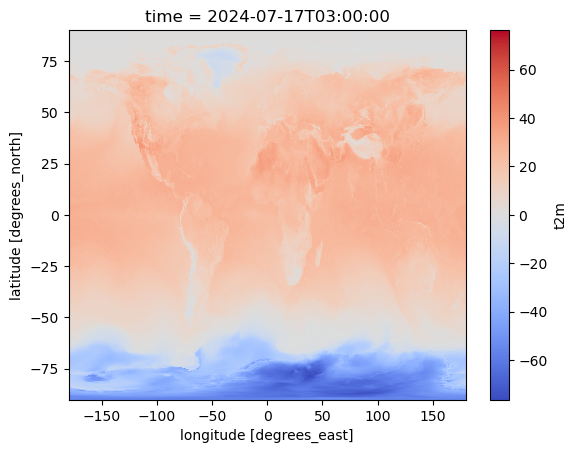

In [43]:
# Plot temperature at 03h on 17-July-2024
ds.t2m[0].plot(cmap=plt.cm.coolwarm)

Text(0.5, 1.0, 'ECMWF - 2m temperature [deg C] forecast July 17, 2024')

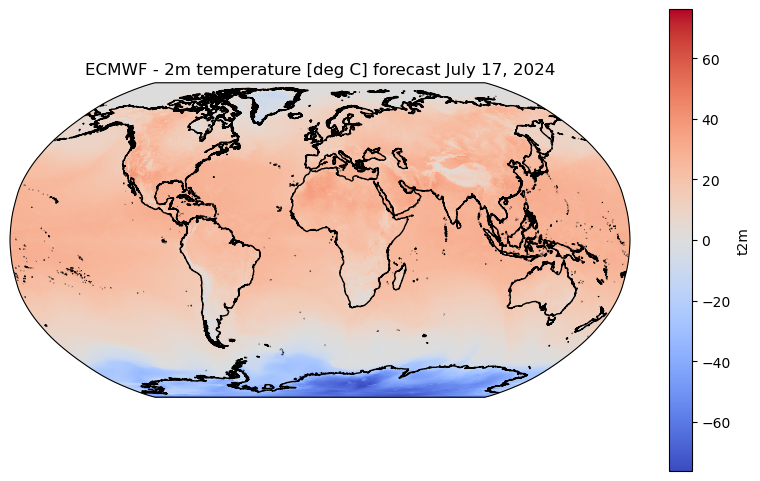

In [44]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
plot = ds.t2m[0].plot(
    cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.6}
)
plt.title("ECMWF - 2m temperature [deg C] forecast July 17, 2024")

### Compute gridded daily averages from 3-hourly temperature. This daily Tmean is required for the subsequent epidemiological analysis (but aggregated to spatial boundaries)

In [45]:
ds_daily_tasmean_17_22July2024 = ds.resample(time='D').mean()
ds_daily_tasmean_17_22July2024

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 7)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2024-07-17 2024-07-18 ... 2024-07-23
Data variables:
    t2m        (time, latitude, longitude) float32 0.5374 0.5374 ... -37.21
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-07-18T11:37 GRIB to CDM+CF via cfgrib-0.9.1...

### Some more demo plots, this time using daily Tmean

Text(0.5, 1.0, 'ECMWF - mean 2m temperature [deg C] forecast for Kingston Upon Thames on July 17-22, 2024')

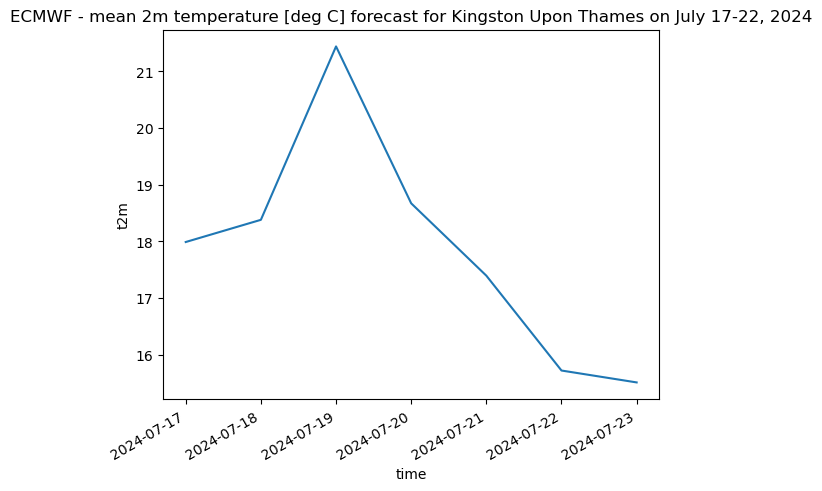

In [47]:
ds_daily_tasmean_17_22July2024.t2m.sel(longitude = -0.31, latitude = 51.41, method='nearest').plot()
plt.title("ECMWF - mean 2m temperature [deg C] forecast for Kingston Upon Thames on July 17-22, 2024")

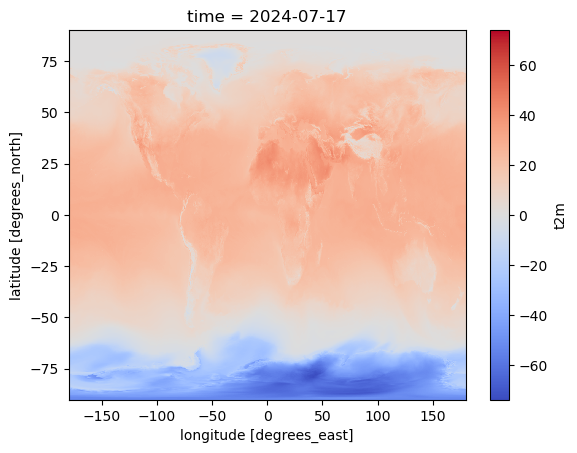

In [48]:
ds_daily_tasmean_17_22July2024.t2m[0].plot(cmap=plt.cm.coolwarm)

### Save as daily 0.25 deg gridded mean temperature (Tmean) as a netcdf file which can then be read in R or Python along with the geographic boundaries (shape files) for spatially aggregating the Tmean.

In [49]:
ds_daily_tasmean_17_22July2024.to_netcdf(path="tas_daily_17_July_22July_2024.nc", mode='w') 